<a href="https://colab.research.google.com/github/sv650s/amazon-review-classification/blob/master/notebooks/deep_learning/6.6.3.2-LSTMB16_15-GloVe_with_stop_nonlemmatized-1m-prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pre-trained embedding using LSTM (with stop words, nonlemmatized)

For this notebook, we will run our 16 unit LSTM using GloVe embedding with 1 million examples to see how to model does.

We are going to only keep 1-star and 5-star ratings to look at model noise

We classifying all ratings, our score with the same architecture is: 0.2959231917086992


# Result

We have pretty high precision for both 1-star and 5-star ratings.

The score for this run was: 0.9485896617148637





In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
DRIVE_DIR = "drive/My Drive/Springboard/capstone"
sys.path.append(DRIVE_DIR)


%tensorflow_version 2.x


import tensorflow as tf
# checl to make sure we are using GPU here
tf.test.gpu_device_name()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
TensorFlow 2.x selected.


'/device:GPU:0'

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, \
    SpatialDropout1D, Flatten, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.initializers import Constant


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight


import pandas as pd
import numpy as np
from IPython.display import SVG
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
import logging


import util.dict_util as du
import util.plot_util as pu
import util.file_util as fu
import util.keras_util as ku
import util.report_util as ru

import random

# fix random seeds
tf.compat.v1.reset_default_graph()
tf.compat.v1.set_random_seed(1)
random.seed(1)
np.random.seed(1)

logging.basicConfig(level=logging.ERROR)

%matplotlib inline
sns.set()


DATE_FORMAT = '%Y-%m-%d'
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
LABEL_COLUMN = "star_rating"
REVIEW_COLUMN = "review_body"


DEBUG = False


LSTM_DIM = 16 # total LSTM units
MODEL_NAME = f"LSTMB{LSTM_DIM}_15"
ARCHITECTURE = f"1x{LSTM_DIM}"
DESCRIPTION = f"1 Layer {LSTM_DIM} (1 and 5 star rating only) LSTM Units, No Dropout, GloVe Embedding (with stop words, nonlemmatized), Balanced Weights"
FEATURE_SET_NAME = "glove_with_stop_nonlemmatized"
PATIENCE = 4

SAMPLES = "1m"

if DEBUG:
  DATA_FILE = f'{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-test-preprocessed.csv'
  MODEL_NAME = f'test-{MODEL_NAME}'
  MISSING_WORDS_FILE = f'{DRIVE_DIR}/reports/glove_embedding-missing_words-test.csv'
else:
  DATA_FILE = f"{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-{SAMPLES}-with_stop_nonlemmatized-preprocessed.csv"
  MISSING_WORDS_FILE = f'{DRIVE_DIR}/reports/glove_embedding-missing_words-{SAMPLES}.csv'
  ku.ModelWrapper.set_report_filename('glove_embedding_with_stop_nonlemmatized-dl_prototype-report.csv')


EMBEDDING_FILE = f'{DRIVE_DIR}/data/embeddings/glove.840B.300d.txt'
EMBEDDING_INDEX_FILE = f'{DRIVE_DIR}/models/glove.840B.300d-embedding_index'


# first layer filter
FILTER1 = 32
# Network Settings
KERNEL_SIZE=3



# length of our embedding - 300 is standard
EMBED_SIZE = 300
EPOCHS  = 50
BATCH_SIZE = 128

# From EDA, we know that 90% of review bodies have 100 words or less, 
# we will use this as our sequence length
MAX_SEQUENCE_LENGTH = 100




# Read file and only keep 1 and 5 star reviews

In [0]:
df = pd.read_csv(DATA_FILE)

df = df[(df[LABEL_COLUMN] == 1) | (df[LABEL_COLUMN] == 5)]
# have to set 5's to 2's so we can compute class weights later
df.loc[df[LABEL_COLUMN] == 5, LABEL_COLUMN] = 2
CLASSES = 2

rating = df[LABEL_COLUMN]
reviews = df[REVIEW_COLUMN]

# Define our score function

In [0]:
def calculate_metric(crd: dict):
  """
  Calculates our model score based on classification report dictionary
  :param crd: classification report dictionary
  :return: model score - float
  """
  metric_1 = mw.crd["1"]["recall"]
  metric_5 = mw.crd["2"]["precision"]
  if metric_1 > 0 and metric_5 > 0:
    model_score = 2 / (1 / metric_1 + 1 / metric_5)
  else:
    model_score = 0
  return model_score

# Preprocessing

In [5]:


# pre-process our lables
# one hot encode our star ratings since Keras/TF requires this for the labels
y = OneHotEncoder().fit_transform(rating.values.reshape(len(rating), 1)).toarray()


# split our data into train and test sets
reviews_train, reviews_test, y_train, y_test = train_test_split(reviews, y, random_state=1)


# Pre-process our features (review body)
t = Tokenizer(oov_token="<UNK>")
# fit the tokenizer on the documents
t.fit_on_texts(reviews_train)
# tokenize both our training and test data
train_sequences = t.texts_to_sequences(reviews_train)
test_sequences = t.texts_to_sequences(reviews_test)

print("Vocabulary size={}".format(len(t.word_counts)))
print("Number of Documents={}".format(t.document_count))


# pad our reviews to the max sequence length
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

print('Train review vectors shape:', X_train.shape, ' Test review vectors shape:', X_test.shape)


Vocabulary size=89257
Number of Documents=506340
Train review vectors shape: (506340, 100)  Test review vectors shape: (168781, 100)


## Load our pre-trained embedding

embeddings_index will be a map where key == word, value == the embedding vector

In [6]:
EMBEDDING_INDEX_FILE = f'{DRIVE_DIR}/models/glove.840B.300d-embedding_index'

embeddings_index = {}

if os.path.exists(f'{EMBEDDING_INDEX_FILE}.npy'):
  print(f'Loading {EMBEDDING_INDEX_FILE}.npy')
  embeddings_index = np.load(f'{EMBEDDING_INDEX_FILE}.npy', 
                             allow_pickle = True).item()
else:
  print('Indexing word vectors.')

  with open(EMBEDDING_FILE) as f:
      for line in f:
          word, coefs = line.split(maxsplit=1)
          coefs = np.fromstring(coefs, 'f', sep=' ')
          embeddings_index[word] = coefs
  np.save(EMBEDDING_INDEX_FILE, embeddings_index)

print(type(embeddings_index))
print(np.shape(embeddings_index))
print('Found %s word vectors.' % len(embeddings_index))




Loading drive/My Drive/Springboard/capstone/models/glove.840B.300d-embedding_index.npy
<class 'dict'>
()
Found 2195884 word vectors.


## Create Embedding Matrix based on our tokenizer

For every word in our vocabulary, we will look up the embedding vector and add the it to our embedding matrix

The matrix will be passed in as weights in our embedding layer later

If there is word that does not exist in the pre-trained embedding vocabulary, we will leave the weights as 0 vector and save off the word into a CSV file later for analysis

In [7]:
# this is a map with key == word, value == index in the vocabulary
word_index = t.word_index
print(f'word_index length: {len(word_index)}')

# we are going to use the entire vocab so we can alter this from the example
# num_words = min(MAX_NUM_WORDS, len(word_index) + 1)

# start with a matrix of 0's
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))

# if a word doesn't exist in our vocabulary, let's save it off
missing_words = []
print(f'embedding_matrix shape: {np.shape(embedding_matrix)}')
for word, i in word_index.items():
    # print(f'word: {word} i: {i}')
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None and np.shape(embedding_vector)[0] == EMBED_SIZE:
        # words not found in embedding index will be all-zeros.
        # print(f'i: {i} embedding_vector shape: {np.shape(embedding_vector)}')
        embedding_matrix[i] = embedding_vector
    else:
      missing_words.append(word)

print(f'Number of missing words from our vocabulary: {len(missing_words)}')



word_index length: 89258
embedding_matrix shape: (89259, 300)
Number of missing words from our vocabulary: 31346


Save off our missing words into a csv file so we can analyze this later

In [0]:
# save missing words into a file so we can analyze it later
missing_words_df = pd.DataFrame(missing_words)
missing_words_df.to_csv(MISSING_WORDS_FILE, index=False)

**Build LSTM Model Architecture**

In [0]:
tf.compat.v1.reset_default_graph()


vocab_size = len(t.word_index)+1

# building our network
model = Sequential()
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
model.add(Embedding(input_dim=vocab_size,
                            output_dim=EMBED_SIZE,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False))
# model.add(Embedding(input_dim=vocab_size, output_dim=EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(LSTM(LSTM_DIM))
model.add(Dense(CLASSES, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["categorical_accuracy"])


In [10]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          26777700  
_________________________________________________________________
lstm (LSTM)                  (None, 16)                20288     
_________________________________________________________________
dense (Dense)                (None, 2)                 34        
Total params: 26,798,022
Trainable params: 20,322
Non-trainable params: 26,777,700
_________________________________________________________________
None


In [11]:
np.shape(y_train)

(506340, 2)

In [12]:

# reduce learning rate if we sense a plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                            #   factor=0.4,
                            #   patience=PATIENCE, 
                            #   min_lr=0.00001,
                            #  mode='auto',
                              restore_best_weights=True)

early_stop = EarlyStopping(monitor='val_loss', 
                           patience=PATIENCE, 
                           verbose=1,
                           restore_best_weights=True)

weights = compute_class_weight('balanced', np.arange(1, CLASSES + 1), rating)
print(f'class weights: {weights}')


mw = ku.ModelWrapper(model, 
                     MODEL_NAME, 
                     ARCHITECTURE,
                     FEATURE_SET_NAME,
                     LABEL_COLUMN, 
                     DATA_FILE, 
                     embed_size=EMBED_SIZE,
                     tokenizer=t,
                     description=DESCRIPTION)

network_history = mw.fit(X_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=1,
                      validation_split=0.2,
                      class_weight=weights,
                      callbacks=[early_stop, reduce_lr])

class weights: [2.40928784 0.63093887]
Number of training examples: 506340
Train on 405072 samples, validate on 101268 samples
Epoch 1/50
405072/405072 [==============================] - 44s 107us/sample - loss: 0.1484 - categorical_accuracy: 0.9426 - val_loss: 0.1049 - val_categorical_accuracy: 0.9613
Epoch 2/50
405072/405072 [==============================] - 36s 90us/sample - loss: 0.0966 - categorical_accuracy: 0.9649 - val_loss: 0.0881 - val_categorical_accuracy: 0.9680
Epoch 3/50
405072/405072 [==============================] - 36s 89us/sample - loss: 0.0853 - categorical_accuracy: 0.9692 - val_loss: 0.0851 - val_categorical_accuracy: 0.9693
Epoch 4/50
405072/405072 [==============================] - 35s 88us/sample - loss: 0.0788 - categorical_accuracy: 0.9718 - val_loss: 0.0814 - val_categorical_accuracy: 0.9708
Epoch 5/50
405072/405072 [==============================] - 35s 87us/sample - loss: 0.0744 - categorical_accuracy: 0.9735 - val_loss: 0.0808 - val_categorical_accuracy:

Number of test: 168781
Running model.evaluate...
168781/168781 [==============================] - 28s 164us/sample - loss: 0.0772 - categorical_accuracy: 0.9733
Running model.predict...
Unencode predictions...
Generating confusion matrix...
Calculating ROC AUC...
(168781, 2)
Getting classification report...
Accuracy: 97.33%


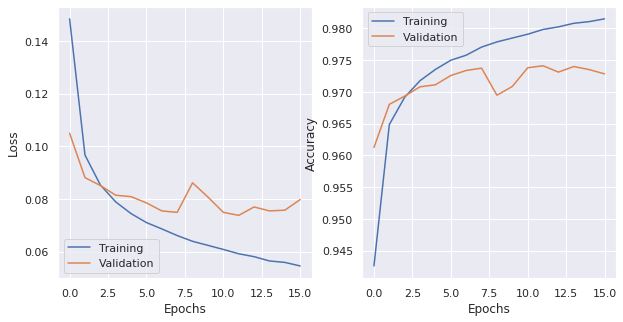


Confusion Matrix
[[ 32550   2340]
 [  2161 131730]]

Classification Report
              precision    recall  f1-score   support

           1       0.94      0.93      0.94     34890
           2       0.98      0.98      0.98    133891

    accuracy                           0.97    168781
   macro avg       0.96      0.96      0.96    168781
weighted avg       0.97      0.97      0.97    168781



drive/My Drive/Springboard/capstone/util/plot_util.py:267: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:267: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:271: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:271: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.
  w

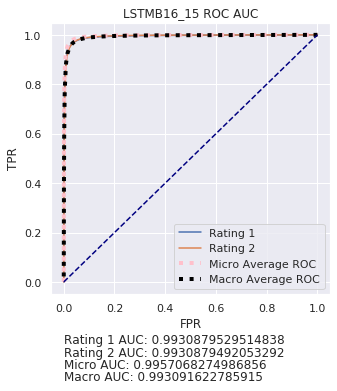

In [13]:

scores = mw.evaluate(X_test, y_test)
print("Accuracy: %.2f%%" % (mw.scores[1]*100))

pu.plot_network_history(mw.network_history, "categorical_accuracy", "val_categorical_accuracy")
plt.show()

print("\nConfusion Matrix")
print(mw.confusion_matrix)

print("\nClassification Report")
print(mw.classification_report)

fig = plt.figure(figsize=(5,5))
pu.plot_roc_auc(mw.model_name, mw.roc_auc, mw.fpr, mw.tpr)



In [0]:
model_score = calculate_metric(mw.crd)

print(f'Score: {model_score}')

**Save off various files**

In [15]:
mw.save(DRIVE_DIR, append_report=True)

description: LSTMB16_15-1x16-glove_with_stop_nonlemmatized-sampling_none-675121-100-star_rating
Saving to report file: drive/My Drive/Springboard/capstone/reports/glove_embedding_with_stop_nonlemmatized-dl_prototype-report.csv
Loading to append to: drive/My Drive/Springboard/capstone/reports/glove_embedding_with_stop_nonlemmatized-dl_prototype-report.csv
{'model_name': 'LSTMB16_15', 'architecture': '1x16', 'description': '1 Layer 16 (1 and 5 star rating only) LSTM Units, No Dropout, GloVe Embedding (with stop words, nonlemmatized), Balanced Weights', 'classification_report': '{"1": {"precision": 0.9377430785629915, "recall": 0.9329320722269991, "f1-score": 0.935331388916826, "support": 34890}, "2": {"precision": 0.9825464309688968, "recall": 0.9838600055268838, "f1-score": 0.9832027795089584, "support": 133891}, "accuracy": 0.973332306361498, "macro avg": {"precision": 0.9601447547659442, "recall": 0.9583960388769415, "f1-score": 0.9592670842128922, "support": 168781}, "weighted avg": 

# Test That Our Models Saved Correctly

In [16]:
from tensorflow.keras.models import load_model

model_loaded = load_model(mw.model_file)
scores = model_loaded.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

# this takes too long for real models
if DEBUG == True:
  y_predict = model_loaded.predict(X_test)
  y_predict_unencoded = ku.unencode(y_predict)
  y_test_unencoded = ku.unencode(y_test)

  # classification report
  print(classification_report(y_test_unencoded, y_predict_unencoded))

  # confusion matrix
  print(confusion_matrix(y_test_unencoded, y_predict_unencoded))


168781/168781 [==============================] - 82s 485us/sample - loss: 0.0772 - categorical_accuracy: 0.9733
Accuracy: 97.33%


In [17]:
print(datetime.now())

2020-02-23 01:12:33.901042
2020-02-23 01:12:33.901042
2020-02-23 01:12:33.901042
